In [1]:
import numpy as np
import cv2
from scipy.interpolate import CubicSpline

from PIL import Image
import matplotlib.pyplot as plt

## 磨皮算法
参考：
- https://zhuanlan.zhihu.com/p/32360617
- https://github.com/YuAo/YUCIHighPassSkinSmoothing

(-0.5, 1799.5, 1589.5, -0.5)

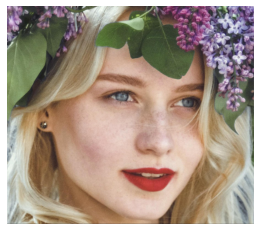

In [2]:
img = cv2.imread('./images/bandian1.jpg')

plt.imshow(img[...,::-1]/255.0)
plt.axis('off')

In [3]:
# # 第一步：双边滤波
# img_bf = cv2.bilateralFilter(img,30,48,42)
# plt.imshow(img_bf[...,::-1]/255.0)
# plt.axis('off')

# plt.imsave('img_ori.jpg',img[...,::-1])
# plt.imsave('img_bif.jpg',img_bf[...,::-1])

# 先实现YUCIHighPassSkinSmoothingMaskGenerator

关于coreImage库的文档在：https://developer.apple.com/library/archive/documentation/GraphicsImaging/Reference/CoreImageFilterReference/



In [4]:
input_img = np.array(img[...,::-1]/255.0,dtype=np.float32) #rgb

In [5]:
# CIExposureAdjust
ea_img = input_img * pow(2,-1.0)

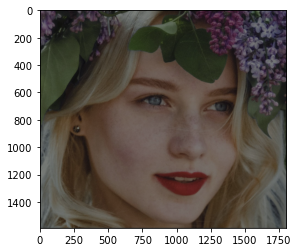

In [6]:
plt.imshow(ea_img)

In [7]:
# YUCIGreenBlueChannelOverlayBlend
base = ea_img[...,1]
overlay = ea_img[...,2]
ba = 2.0*overlay*base
ba_img = np.zeros((ba.shape[0],ba.shape[1],3),dtype=np.float32)
ba_img[...,0] = ba
ba_img[...,1] = ba
ba_img[...,2] = ba

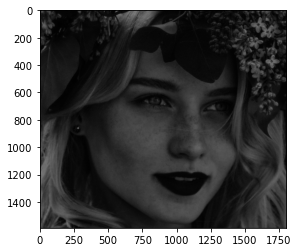

In [8]:
plt.imshow(ba_img)

In [9]:
from PIL import ImageFilter

In [10]:
def np2pil(numpy_image):
    return Image.fromarray(np.uint8(numpy_image*255.0)).convert('RGB')

(-0.5, 1799.5, 1589.5, -0.5)

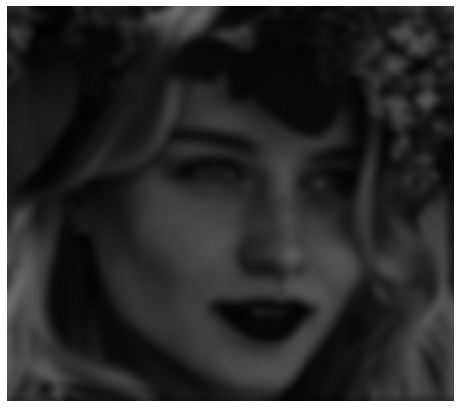

In [11]:
# YUCIHighPass
# 先进行高斯模糊 
radius = int(np.ceil(7.0*input_img.shape[0]/750.0))
# # opencv的方法（不理想）
# if(np.ceil(7.0*img.shape[0]/750.0)%2.0 == 0):
#     radius = radius + 1
# blur_img = cv2.GaussianBlur(ba_img,(99,99),0) #cv2.bilateralFilter(ba_img,radius,75,75)
# plt.figure(figsize=(8,8))
# plt.imshow(blur_img)
# plt.axis('off')
# PIL的方法
pil_img = np2pil(ba_img)
pil_blur = pil_img.filter(ImageFilter.GaussianBlur(radius))
blur_img = np.asarray(pil_blur,np.float32)/255.0
plt.figure(figsize=(8,8))
plt.imshow(blur_img)
plt.axis('off')

In [12]:
# 再进行YUCIHighPass
hp_img = ba_img - blur_img + 0.5

(-0.5, 1799.5, 1589.5, -0.5)

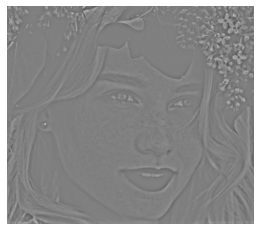

In [13]:
plt.imshow(hp_img)
plt.axis('off')

In [14]:
# YUCIHighPassSkinSmoothingMaskBoost
hardLightColor = hp_img[...,2]
[x1,y1] = np.where(hardLightColor<0.5)
[x2,y2] = np.where(hardLightColor>=0.5)
for i in range(3):
    hardLightColor[x1,y1] = hardLightColor[x1,y1]*hardLightColor[x1,y1]*2.0
    hardLightColor[x2,y2] = 1.0 - (1.0 - hardLightColor[x2,y2]) * (1.0 - hardLightColor[x2,y2]) * 2.0
k = 255.0/(164.0-75.0);
hardLightColor = (hardLightColor - 75.0/255.0) * k
hpss_img = np.zeros((hardLightColor.shape[0],hardLightColor.shape[1],3))
hpss_img[...,0] = hardLightColor
hpss_img[...,1] = hardLightColor
hpss_img[...,2] = hardLightColor

hpss_img = np.clip(hpss_img,0,1)

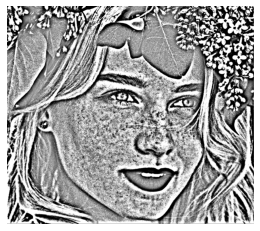

In [15]:
plt.imshow(hpss_img)
plt.axis('off')
plt.imsave('hpss_img.jpg',hpss_img)

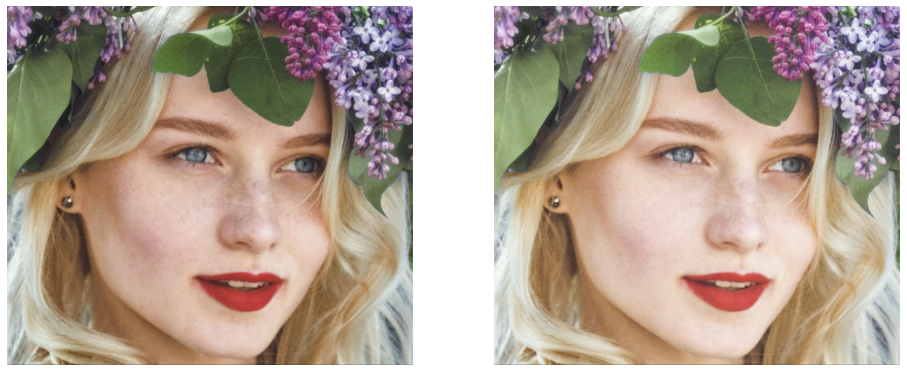

In [16]:
# RGB tone curve 
# 先利用控制点生成cubic spline曲线
# 参照https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.CubicSpline.html#scipy.interpolate.CubicSpline
x = [0,120.0/255.0,1]
y = [0,146.0/255.0,1]#146
cs = CubicSpline(x,y)
tc_img = cs(input_img)

plt.figure(figsize=(16,16))
plt.subplot(121)
plt.imshow(input_img)
plt.axis('off')
plt.subplot(122)
plt.imshow(tc_img)
plt.axis('off')
plt.imsave('light_img.jpg',tc_img)

(-0.5, 1799.5, 1589.5, -0.5)

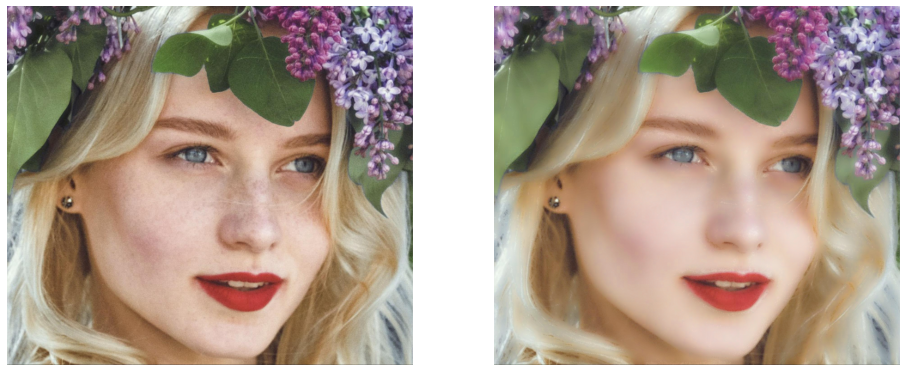

In [17]:
# blendWithMaskFilter
blend_img = input_img * hpss_img + tc_img*(1-hpss_img)

plt.figure(figsize=(16,16))
plt.subplot(121)
plt.imshow(input_img)
plt.axis('off')
plt.subplot(122)
plt.imshow(blend_img)
plt.imsave('img_blend.jpg',blend_img)
plt.axis('off')

In [18]:
# sharpen
from PIL import ImageEnhance
enhancer = ImageEnhance.Sharpness(np2pil(blend_img))
img_sharp = enhancer.enhance(2)
result = np.array(img_sharp,np.float32)/255.0

(-0.5, 1799.5, 1589.5, -0.5)

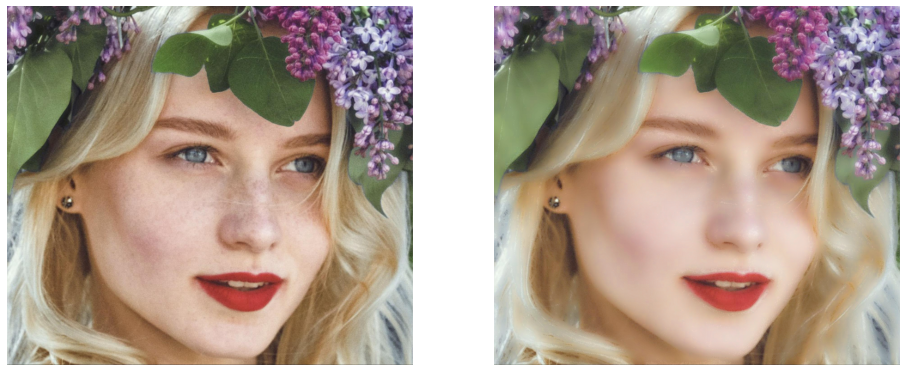

In [19]:
plt.figure(figsize=(16,16))
plt.subplot(121)
plt.imshow(input_img)
plt.axis('off')
plt.subplot(122)
plt.imshow(result)
plt.axis('off')